# Taxi Order Forecasting

The company "Cheotenkoe Taxi" has collected historical data on taxi orders at airports. To attract more drivers during peak load periods, it is necessary to forecast the number of taxi orders for the next hour.



**Tasks:**

- Load the data and resample it by one hour.
- Analyze the data.
- Train different models with various hyperparameters. Create a test set with a size of 10% of the original data.
- Evaluate the models on the test set and draw conclusions. Achieve an RMSE (Root Mean Square Error) on the test set of no more than 48.

Признаки: 

`num_orders` – number of orders

## Data pre-processing

### Import Libraries

In [1]:
!pip install --upgrade numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 2.2 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.1 which is incompatible.


In [2]:
!pip install statsmodels

In [3]:

!pip install catboost

In [4]:
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
warnings.filterwarnings("ignore")

### Helper functions

In [5]:
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))
    
def get_numerical_summary(data):
    total = data.shape[0]
    missing_columns = [col for col in data.columns if data[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = data[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    else:
        print('There are no missing values')

### Import Data

In [6]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net///datasets/taxi.csv', index_col=[0], parse_dates=[0])

## EDA

In [7]:
get_data_info(data)

,num_orders
datetime,
2018-06-18 00:30:00,27
2018-07-29 02:40:00,26
2018-07-10 22:00:00,8
2018-04-11 22:40:00,21
2018-03-04 07:40:00,4


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [8]:
get_numerical_summary(data)

Пропусков нет


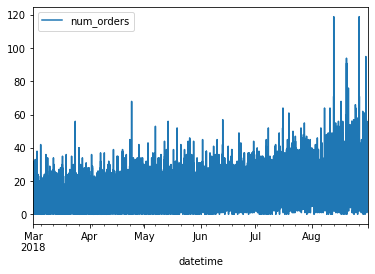

In [9]:
data.plot();

### Resampling by hour 

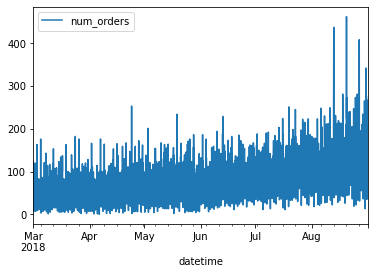

In [10]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.plot();

### Moving Standard Deviation

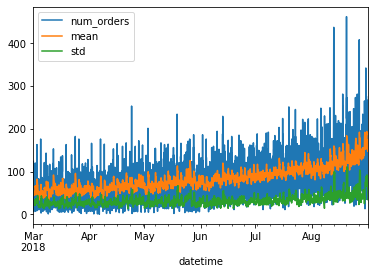

In [11]:
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot();

Here we observe that we have a non-stationary time series. The standard deviation is increasing over time.

### Trends and seasonality analysis

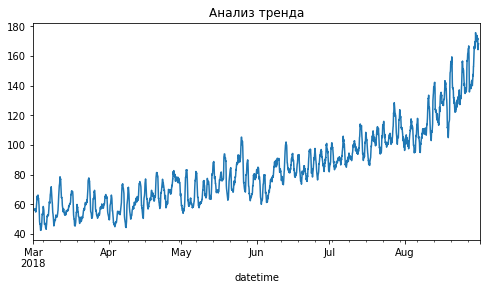

In [12]:
decomposed_trend = seasonal_decompose(data['num_orders'].resample('1H').sum())
 
plt.figure(figsize=(8, 4))
ax = decomposed_trend.trend.plot()
ax.set_title('Trend Analysis')
plt.show()


From July to August, we observe an increase in the number of taxi orders. This period shows a positive trend in the demand for taxi services, indicating a potential surge in transportation needs during this time. It could be influenced by various factors such as summer vacations, increased travel activities, events, or other seasonal factors specific to the region.

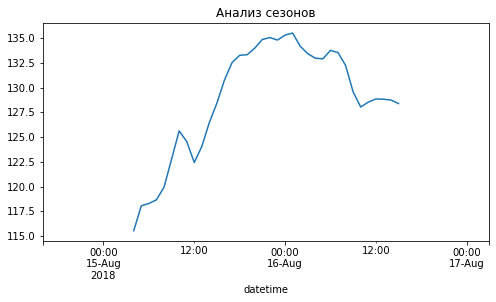

In [13]:
decomposed_seasonal = seasonal_decompose(data[4000:4060]['num_orders'].resample('1H').sum())
plt.figure(figsize=(8, 4))
ax = decomposed_seasonal.trend.plot()
ax.set_title('Seasonality Analysis')
plt.show()

The majority of orders are concentrated in the evening between 18:00 and 00:00. This pattern suggests that people are likely ordering taxis for evening events or activities when public transportation may be less available or less convenient. It could include going out for dinner, attending social gatherings, or enjoying nightlife entertainment. 

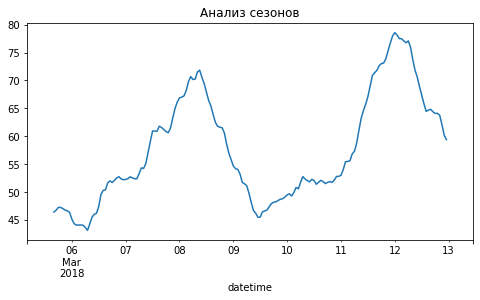

In [14]:
decomposed_seasonal = seasonal_decompose(data[100:300]['num_orders'].resample('1H').sum())
plt.figure(figsize=(8, 4))
ax = decomposed_seasonal.trend.plot()
ax.set_title('Seasonality Analysis')
plt.show()

Here, we observe a peak in activity on Mondays. This could be attributed to various factors such as business travel, weekend travelers returning home, or increased demand for transportation at the start of the workweek. 

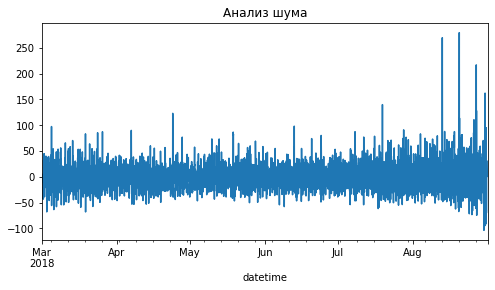

In [15]:
decomposed_resid = seasonal_decompose(data['num_orders'].resample('1H').sum())
 
plt.figure(figsize=(8, 4))
ax = decomposed_resid.resid.plot(ax=plt.gca())
ax.set_title('Noise analysis')
plt.show()

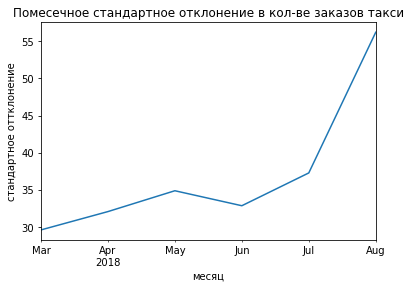

In [16]:
data.resample('M')['num_orders'].std().plot()
plt.title('Monthly Standard Deviation of Taxi Orders')
plt.xlabel('Month')
plt.ylabel('Standard Deviation')
plt.show()

We observe the most noise in August. This may indicate that there were events happening during this month that affected the number of taxi orders. For example, there could be holidays, festivals, or other major events that attracted a large number of people and increased the demand for taxis. Additionally, the summer season can also be a period of increased activity in the city, which can further contribute to the increase in taxi orders.

### Finding the difference of the time series

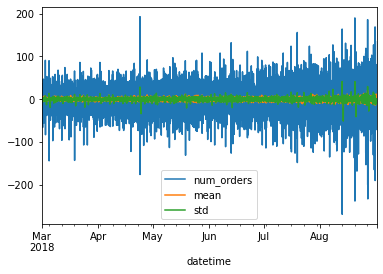

In [17]:
data_diff = data.diff()
data_diff.plot();

## Model traning 

### Features generation 

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size, min_periods=1).mean()

make_features(data_diff, 24, 24)
print(data_diff.head())


                     num_orders  mean  std  dayofweek  hour  lag_1  lag_2  \
datetime                                                                    
2018-03-01 00:00:00         NaN   NaN  NaN          3     0    NaN    NaN   
2018-03-01 01:00:00       -39.0   NaN  NaN          3     1    NaN    NaN   
2018-03-01 02:00:00       -14.0   NaN  NaN          3     2  -39.0    NaN   
2018-03-01 03:00:00        -5.0   NaN  NaN          3     3  -14.0  -39.0   
2018-03-01 04:00:00       -23.0   NaN  NaN          3     4   -5.0  -14.0   

                     lag_3  lag_4  lag_5  ...  lag_16  lag_17  lag_18  lag_19  \
datetime                                  ...                                   
2018-03-01 00:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00    NaN    NaN    NaN  ...     NaN  

### Splitting the data

In [19]:
data_diff = data_diff.resample('1H').sum()
train, test = train_test_split(data_diff, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [20]:
train = train.dropna()
test = test.dropna()

X_train = train.drop(['num_orders'],axis = 1) 
y_train = train['num_orders'] 

X_test = test.drop(['num_orders'],axis = 1) 
y_test = test['num_orders'] 

In [21]:
X_train.shape

(3974, 29)

In [22]:
X_test.shape

(442, 29)

### Linear Regression

In [23]:
def rmse(y, predictions):
    return (((y_test-predictions)**2).mean())**0.5

In [24]:
%%time
model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
def rmse(y, predictions):
    return (((y_test-predictions)**2).mean())**0.5
rmse_lr = rmse(y_test, predictions)
print("RMSE LR:",rmse_lr)

RMSE LR: 0.8122330879997175
CPU times: user 2.18 s, sys: 21.3 ms, total: 2.2 s
Wall time: 2.18 s


The RMSE value is too low compared to other models. We will now test it on the test dataset to validate its performance.

### Random Forest

In [25]:
%%time
model_rf = RandomForestRegressor(random_state=42, n_estimators=100)
model_rf.fit(X_train, y_train)

predictions = model_rf.predict(X_test)

rmse_rf = rmse(y_test, predictions)
print("RMSE RF:",rmse_rf)

RMSE RF: 35.8340142767388
CPU times: user 5.81 s, sys: 280 ms, total: 6.09 s
Wall time: 4.65 s


We obtained satisfactory results. However, since we are working with time series data, we need to try different modeling techniques and data splitting methods that are suitable for this task. Let's utilize TimeSeriesSplit to address the specific requirements of our problem.

### Time Series Split

In [26]:
cv = TimeSeriesSplit(n_splits=6)
print(cv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None)


### Cat Boost Regressor Time Series Split

In [27]:
%%time
scoring_fit = 'neg_mean_squared_error'

cat_features = ['hour']

model_cat = CatBoostRegressor(cat_features=cat_features,verbose = False)
param_grid  = {'n_estimators':[50,100,150],
               'max_depth':[5,10],
}
gs = GridSearchCV (model_cat,param_grid,cv = cv,scoring = scoring_fit)
fitted_cat = gs.fit(X_train,y_train,cat_features=cat_features)

pred = fitted_cat.predict(X_test) 
def rmse(y, predictions):
    return (((y_test-pred)**2).mean())**0.5
rmse_cat = rmse(y_test, pred) 
print(rmse_cat)

25.989676485386145
CPU times: user 5min 35s, sys: 4.71 s, total: 5min 40s
Wall time: 38 s


### Random Forest Time Series Split

In [28]:
%%time
scoring_fit = 'neg_mean_squared_error'

model_rf = RandomForestRegressor(random_state=42)

param_grid  = {'n_estimators':[100,150,200],
               'max_depth':[10,20],
}

gs = GridSearchCV(model_rf, param_grid, cv=cv, scoring=scoring_fit, n_jobs=-1)

fitted_rf = gs.fit(X_train, y_train)

pred = fitted_rf.predict(X_test)

def rmse(y, predictions):
    return (((y_test-pred)**2).mean())**0.5

rmse_rf_2 = rmse(y_test, pred) 
print("RMSE RF:", rmse_rf_2)


RMSE RF: 35.77429389979211
CPU times: user 7.1 s, sys: 168 ms, total: 7.27 s
Wall time: 32.6 s


In [29]:
result_models = pd.Series([rmse_lr, rmse_rf, rmse_cat, rmse_rf_2], 
                          index=["RMSE LR", "RMSE RF", "RMSE Catboost", "RMSE RF Time Series Split"])

result_models.sort_values()



RMSE линейная регрессия                    0.812233
RMSE Catboost                             25.989676
RMSE Случайный лес с Time Series Split    35.774294
RMSE Случайный лес                        35.834014
dtype: float64

## Model Testing

In [37]:
test_predictions = model.predict(X_test)
rmse_test_lr = rmse(y_test, test_predictions)
print("RMSE:", rmse_test_lr)


RMSE: 35.77429389979211


In [32]:

def best_test_models(model, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start_time
    y_pred = model.predict(X_test)
    rmse_test = rmse(y_test, y_pred)

    return {'RMSE test': rmse_test, 'fit time, s': fit_time}

catboost_model = CatBoostRegressor(verbose=False, n_estimators=100, max_depth=10)
tree_model = RandomForestRegressor(n_estimators=150, max_depth=20)

catboost_result = best_test_models(catboost_model, X_test, y_test)
tree_result = best_test_models(tree_model, X_test, y_test)

results = pd.DataFrame({
    'Model Name': ['CatBoostRegressor', 'RandomForestRegressor'],
    'RMSE test': [catboost_result['RMSE test'], tree_result['RMSE test']],
    'fit time, s': [catboost_result['fit time, s'], tree_result['fit time, s']]
})
results


,Model Name,RMSE test,"fit time, s"
0,CatBoostRegressor,35.774294,2.433636
1,RandomForestRegressor,35.774294,7.312636


In [33]:
y_pred_cat = catboost_model.predict(X_test)
y_pred_dt = tree_model.predict(X_test)

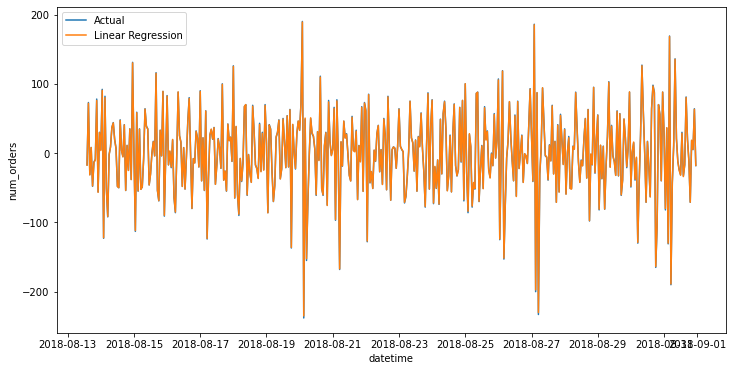

In [34]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=y_test.index, y=y_test, label='Actual')
sns.lineplot(x=y_test.index, y=test_predictions, label='Linear Regression')

plt.legend()
plt.show()



The predictions closely matching the target variable could indicate that the linear regression model is well-suited for this type of data. However, it's important to exercise caution and not solely rely on these seemingly excellent results. There is a possibility that the model may not be reliable, and further evaluation and validation are necessary to ensure its effectiveness.

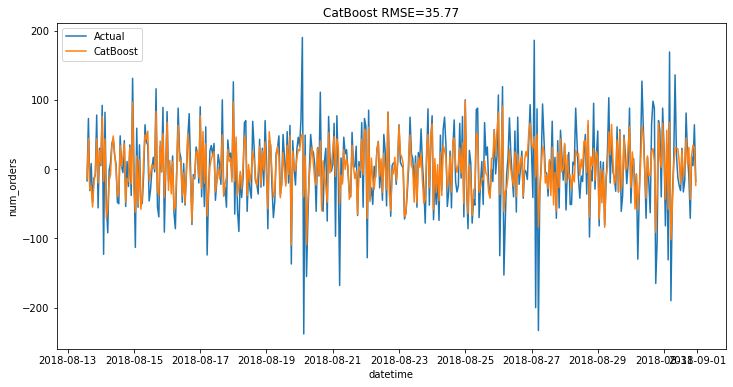

In [35]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=y_test.index, y=y_test, label='Actual')
sns.lineplot(x=y_test.index, y=y_pred_cat, label='CatBoost')
plt.title(f'CatBoost RMSE={catboost_result["RMSE test"]:.2f}')
plt.legend()
plt.show()

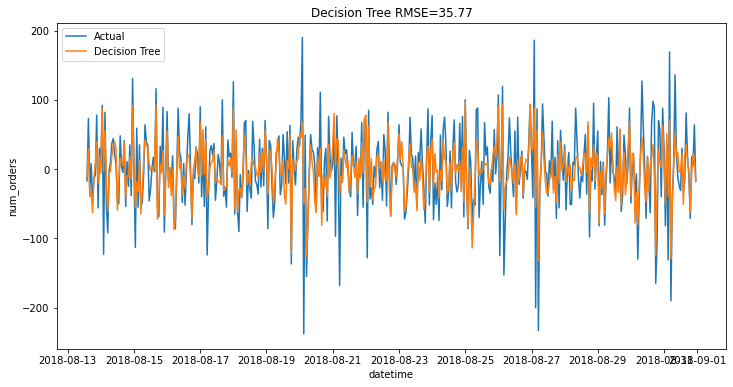

In [36]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=y_test.index, y=y_test, label='Actual')
sns.lineplot(x=y_test.index, y=y_pred_dt, label='Decision Tree')
plt.title(f'Decision Tree RMSE={tree_result["RMSE test"]:.2f}')
plt.legend()
plt.show()

The similarity in the graphs and the comparable RMSE values could be attributed to the small size of the test set. However, there are differences in the training times of the models. Considering the faster training time, we ultimately choose the CatBoostRegressor as our preferred model.

### Conclusions

Before working with the data, we examined the trend and seasonality of the taxi booking data. It was found that the number of taxi orders is dependent on the day of the week and the time of day. For example, taxi bookings are more frequent on holidays and in the evenings on weekdays, which may be attributed to the cessation of public transportation during those times.

We chose regression models to forecast taxi bookings for the next hour. Initially, we tested the models using a 10% holdout test set, followed by cross-validation using Time Series Split. The best-performing models were CatBoost Regressor, DecisionTreeRegressor, and Linear Regression. Increasing the size of the rolling window from 4,4 to 24,24 distorted the performance of Linear Regression, but had minimal impact on the other models. This demonstrates that more complex models tend to be more robust in handling the data.
